In [1]:
import os
import sys
import pickle

import scipy.io as sio
import numpy as np
import torch
import torchvision
from torchvision import transforms

import h5py
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
import time

# Root directory of the project
ROOT_DIR = os.path.abspath("")
sys.path.append(ROOT_DIR)  # To find local version of the library

from humanware.svhn.utils import load_obj

%matplotlib inline

In [2]:
traindata_dir = 'data/SVHN/train/'
extradata_dir = 'data/SVHN/extra/'

filename = 'labels'
metadata_train = load_obj(traindata_dir, filename)
metadata_extra = load_obj(extradata_dir, filename)


## Create custom dataloader.

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

In [3]:
from torch.utils import data

class SVHNDataset(data.Dataset):
    
    def __init__(self, metadata, data_dir, transform=None):
        """
        Args:
            labels (dict): Dictionary containing all labels and metadata
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata = metadata
        self.data_dir = data_dir
        self.transform = transform
        
        
    def __len__(self):
        return len(self.metadata)

    
    def __getitem__(self, index):
        '''
        Parameters
        ----------
        index : int
            The index of the dataset

        Returns
        -------
        X : PIL objet
        
        y : dict
            The metadata associated to the image in dict form.

        '''
        'Generates one sample of data'

        img_name = os.path.join(self.data_dir,
                                self.metadata[index]['filename'])
        
        # Load data and get raw metadata (labels & boxes)
        image = Image.open(img_name)
        metadata_raw = self.metadata[index]['metadata']

        labels, boxes = extract_labels_boxes(metadata_raw)
        
        metadata = {'labels': labels, 'boxes': boxes}
        
        sample = {'image': image, 'metadata': metadata}
        
        if self.transform:
            sample = self.transform(sample)

        return sample



## Create custom transformations

In [4]:
class FirstCrop(object):
    """Crop the image such that all bounding boxes +30% in x,y are contained in the image.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, pad_size):

        self.pad_size = pad_size

    def __call__(self, sample):
        
        image = sample['image']
        
        labels, boxes = sample['metadata']['labels'], sample['metadata']['boxes'] 

        outer_box = extract_outer_box(sample, padding=self.pad_size)
        outer_box = np.round(outer_box).astype('int')
        
        x1_tot, x2_tot, y1_tot, y2_tot = outer_box

        boxes_cropped = boxes
        boxes_cropped[:,0:2] -= x1_tot
        boxes_cropped[:,2:] -= y1_tot

        img_cropped = image.crop((x1_tot,y1_tot,x2_tot,y2_tot))
        
        metadata = {'boxes': boxes_cropped, 'labels': labels}
        
        return {'image': img_cropped, 'metadata': metadata}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, boxes, labels = sample['image'], sample['metadata']['boxes'], sample['metadata']['labels']
      
        h, w = np.asarray(image).shape[:2]

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image_scaled = image.resize((new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        
        boxes = boxes.astype('float64')
        boxes[:,:2] *= (new_w / w)
        boxes[:, 2:] *= (new_h / h)
        boxes = boxes.astype('int64')
        
        metadata = {'boxes': boxes, 'labels': labels}

        return {'image': image_scaled, 'metadata': metadata}

    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes, labels = sample['image'], sample['metadata']['boxes'], sample['metadata']['labels']

        h, w = np.asarray(image).shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image_cropped = image.crop((left,top,left+new_w,top+new_h))

        boxes[:, 0:2] -= left
        boxes[:, 2:] -= top
                
        boxes[:, :2] = np.clip(boxes[:, :2], 0, new_w-1)
        boxes[:, 2:] = np.clip(boxes[:, 2:], 0, new_h-1)
        
        metadata = {'boxes': boxes, 'labels': labels}

        return {'image': image_cropped, 'metadata': metadata}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes, labels = sample['image'], sample['metadata']['boxes'], sample['metadata']['labels']
        
        image = np.asarray(image)
        image = image - np.mean(image)
        assert image.shape == (54, 54, 3)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()

        
        # TODO
        # Process boxes
        
        labels = np.asarray(labels)
        
        # Target is a 1x6 vector, where [0] is the number of digits and 
        # targets[1:targets[0]] is the digit sequence.
        # i.e. the sequence 157 is represented by target [3,1,5,5,7,-1,-1]
        target = -np.ones(6)
        target[0] = len(labels)

        for jj in range(len(labels)):

            target[jj+1] = labels[jj]
            
        target = torch.from_numpy(target).int()        
#         metadata = {'boxes': boxes, 'labels': labels}
        
        return {'image': image,
                'target': target}


In [5]:
## code to extract bboxes
## Inspiration: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py

def extract_labels_boxes(meta):
    '''Extract the labels and boxes from a given sample'''
    
#     meta = sample['metadata']
    N = len(meta['label']) # Number of digits in image

    labels = [] # Digits present in image
    boxes = [] # bboxes present in image

    # Extract digit boxes and labels
    for jj in range(N):
        labels.append(meta['label'][jj])
        y1 = meta['top'][jj]
        y2 = y1+meta['height'][jj]
        x1 = meta['left'][jj]
        x2 = x1 + meta['width'][jj]

        boxes.append((x1,x2,y1,y2))
        
    boxes = np.asarray(boxes)
        
    return labels, boxes


def extract_outer_box(sample, padding=0.3):
    
    img_shape = np.asarray(sample['image']).shape
    boxes = sample['metadata']['boxes']

    x1_tot = np.min(boxes[:,0])
    x2_tot = np.max(boxes[:,1])
    y1_tot = np.min(boxes[:,2])
    y2_tot = np.max(boxes[:,3])
    
    x1_tot -= padding/2*(x2_tot-x1_tot)
    x2_tot += padding/2*(x2_tot-x1_tot)
    y1_tot -= padding/2*(y2_tot-y1_tot)
    y2_tot += padding/2*(y2_tot-y1_tot)
    
    x1_tot = max(0, x1_tot)
    x2_tot = min(x2_tot, img_shape[1]-1)
    y1_tot = max(0, y1_tot)
    y2_tot = min(y2_tot, img_shape[0]-1)
    
    
    outer_bbox = (x1_tot, x2_tot, y1_tot, y2_tot)
        
    return outer_bbox

    
def visualize_sample(sample, outer_bbox=None):
    
    img = sample['image']
    boxes = sample['metadata']['boxes']    
    labels = sample['metadata']['labels']    

    # Display image
    _, ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(img)
    
    
    N = len(labels) # Number of digits in image
    
    # Show individual boxes and labels
    for i in range(N):
        
        # Show bounding boxes
        c = ['r','k']
        if boxes is not None:
            x1, x2, y1, y2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=c[i % 2], facecolor='none')
            ax.add_patch(p)
            
            # Show Label
            caption = labels[i]
            ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

    if outer_bbox is not None:

        x1_tot, x2_tot, y1_tot, y2_tot = outer_bbox

        p2 = patches.Rectangle((x1_tot, y1_tot), x2_tot - x1_tot, y2_tot - y1_tot, linewidth=2,
                            alpha=0.7, linestyle="dashed",
                            edgecolor='blue', facecolor='none')
        ax.add_patch(p2)


Index:  51


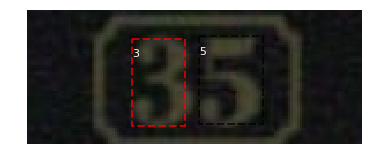

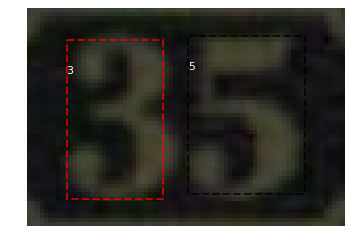

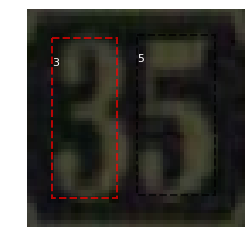

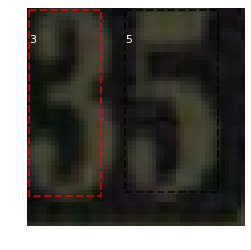

In [6]:
from torchvision import transforms, utils


traindata = SVHNDataset(metadata_train, traindata_dir)

firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()

transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                ])

index = 51 #np.random.randint(len(traindata))
print("Index: ", index)
sample = traindata[index] 
visualize_sample(sample)

for i, tsfrm in enumerate([firstcrop, rescale, random_crop]):
    
    sample = tsfrm(sample)
    visualize_sample(sample)


In [7]:
# Create dataloader

from torch.utils.data import DataLoader

firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()


transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                to_tensor])

transformed_dataset = SVHNDataset(metadata_train, data_dir=traindata_dir, transform=transform)
traindata = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

In [11]:
# Define a placeholder CNN

import torch.nn as nn
import torch.nn.functional as F
nn.CrossEntropyLoss


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(6400, 120)

        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
        x = x.view(1, -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = F.softmax(x, dim=1)
        
        return x


net = Net()


In [12]:
for i, batch in enumerate(traindata, 0):
    # get the inputs
    inputs, targets = batch['image'],batch['target'] 
    
    out = net.forward(inputs)
    if i > 1:
        break

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff603106598>
Traceback (most recent call last):
  File "/home/jerpint/.local/share/virtualenvs/text-detection-NiECicAQ/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/jerpint/.local/share/virtualenvs/text-detection-NiECicAQ/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/jerpint/miniconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/jerpint/.local/share/virtualenvs/text-detection-NiECicAQ/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/jerpint/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/jerpint/miniconda3/lib/python3.7/m

Get useful insight into data

In [ ]:
n_digits_train = 0
n_digits_extra = 0

for ii in metadata_train:
    
    n_digits_train += len(metadata_train[ii]['metadata']['label'])
    
for ii in metadata_extra:
    
    n_digits_extra += len(metadata_extra[ii]['metadata']['label'])


print('total number of digits: ', n_digits_train + n_digits_extra)

In [ ]:
# Get smallest dimensions of images possible
# Slow since you have to load every image into memory

im_width = []
im_height =  []
for jj in range(len(traindata)):
    
    shape = np.asarray(traindata[jj]['image']).shape
    im_height.append(shape[0])
    im_width.append(shape[1])
    
im_width = np.asarray(im_width)
im_height = np.asarray(im_height)

In [ ]:
# Explore dataset for cleaning

# Minimum width and height of images
print("minimum image width", np.min(im_width))
print("minimum image height", np.min(im_height))


#
total = np.sum(np.logical_or(im_height < 28, im_width < 28))

print('total number of image in dataset: ', len(traindata))
print('total number of images that are too small', total)

In [ ]:
## Show sample image that is too small

index = np.argmin(im_height)
visualize_sample(traindata, idx=index)

sample = traindata[index]
print(sample['metadata']['label'])
np.asarray(sample['image']).shape

In [ ]:
# Add example of at least one transform
# use imgaug